## Asymptotics

- $Y = \alpha + \beta X + \varepsilon$, with $E[\varepsilon|X]=0$ and $Var(\varepsilon|X)=\sigma^2$.  
- OLS estimate:  
$$\hat{\beta} \;=\; \frac{\sum\,(X_i - \bar{X})(Y_i - \bar{Y})}{\sum\,(X_i - \bar{X})^2}.$$  
- As $n \to \infty$, $\sqrt{n}\,(\hat{\beta}-\beta)\;\to\;N(0,V)$.  
  - $V = \frac{\sigma^2}{Var(X)}$.  
  - $\hat{V}$ often estimated by $\hat{\sigma}^2 / \sum\,(X_i-\bar{X})^2$.

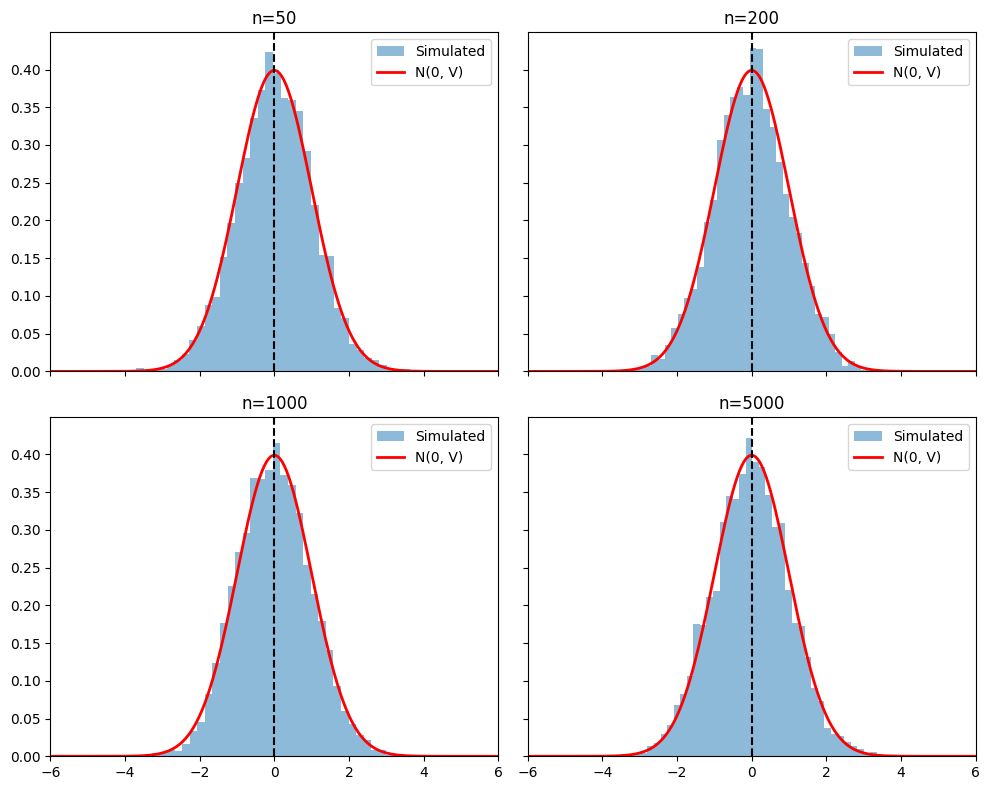

In [3]:
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import norm

np.random.seed(0)

n_sim     = 5000
n_values  = [50, 200, 1000, 5000]
beta_true = 2.0
sigma_true = 1.0
V         = sigma_true**2  # for X ~ N(0, 1)

fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()

for i, n in enumerate(n_values):
    estimates = []
    sqrt_n = np.sqrt(n)
    
    for _ in range(n_sim):
        X   = np.random.randn(n)
        eps = sigma_true * np.random.randn(n)
        Y   = 1.0 + beta_true * X + eps
        
        X_ = sm.add_constant(X)
        model = sm.OLS(Y, X_).fit()
        beta_hat = model.params[1]
        
        estimates.append(sqrt_n*(beta_hat - beta_true))

    ax = axes[i]
    ax.hist(estimates, bins=40, density=True, alpha=0.5, label='Simulated')
    
    x = np.linspace(-6, 6, 200)
    ax.plot(x, norm.pdf(x, 0, np.sqrt(V)), 'r-', lw=2, label='N(0, V)')
    ax.axvline(0, color='k', linestyle='--')
    ax.set_xlim([-6, 6])
    ax.set_title(f'n={n}')
    ax.legend()

plt.tight_layout()
plt.show()


## Influence Functions

### 1. Mean
- Estimator: $ \hat{\mu} = \frac{1}{n} \sum_{i=1}^n y_i $
- Influence Function: $ \text{IF}_i = y_i - \hat{\mu} $
- Intuition: Measures how the deviation of $y_i$ from the mean affects the estimate.

### 2. Variance
- Estimator: $ \hat{\sigma}^2 = \frac{1}{n} \sum_{i=1}^n (y_i - \hat{\mu})^2 $
- Influence Function: $ \text{IF}_i = (y_i - \hat{\mu})^2 - \hat{\sigma}^2 $
- Intuition: Observes the squared deviation of each $y_i$ from the mean compared to the overall variance.

### 3. OLS Coefficients ($\beta$)
- Estimator: $ \hat{\beta} = (X'X)^{-1} X'Y $
- Influence Function: $ \text{IF}_i = (X'X)^{-1} x_i (y_i - x_i'\hat{\beta}) $
- Intuition: Depends on both leverage ($x_i$) and residual ($y_i - x_i'\hat{\beta}$).

### 4. Median
- Estimator: $ \hat{m} = \text{Median}(y) $
- Influence Function:  
  $$
  \psi_{\hat{m}}(y_i) =
  \begin{cases} 
    \frac{0.5}{f_Y(\hat{m})} & \text{if } y_i > \hat{m}, \\
    0 & \text{if } y_i = \hat{m}, \\
    -\frac{0.5}{f_Y(\hat{m})} & \text{if } y_i < \hat{m}.
  \end{cases}
  $$
- Intuition: Measures how observations above or below the median influence its location. Depends on the density $f_Y(\hat{m})$ at the median.

### 5. Covariance
- Estimator: $ \hat{\text{Cov}}(X, Y) = \frac{1}{n} \sum_{i=1}^n (x_i - \hat{\mu}_X)(y_i - \hat{\mu}_Y) $
- Influence Function: $ \text{IF}_i = (x_i - \hat{\mu}_X)(y_i - \hat{\mu}_Y) - \hat{\text{Cov}}(X, Y) $
- Intuition: Measures how deviations of $x_i$ and $y_i$ from their means influence the covariance.

### 6. Weighted Mean
- Estimator: $ \hat{\mu}_w = \frac{\sum_{i=1}^n w_i y_i}{\sum_{i=1}^n w_i} $
- Influence Function: $ \psi_{\hat{\mu}_w}(y_i, w_i) = \frac{w_i}{\mathbb{E}[W]}(y_i - \hat{\mu}_w) $
- Intuition: Adjusts the influence of each observation based on its weight $w_i$.

### 7. Inverse Weighted Mean
- Estimator: $ \hat{\mu}_{w_{\text{inv}}} = \frac{\sum_{i=1}^n w_i y_i}{\sum_{i=1}^n w_i}, \quad w_i \propto \frac{1}{x_i + c} $
- Influence Function: $ \psi_{\hat{\mu}_{w_{\text{inv}}}}(y_i, w_i) = \frac{w_i}{\mathbb{E}[W]}(y_i - \hat{\mu}_{w_{\text{inv}}}) $
- Intuition: Gives lower weights to larger values of $x_i$, reducing their influence on the weighted mean.

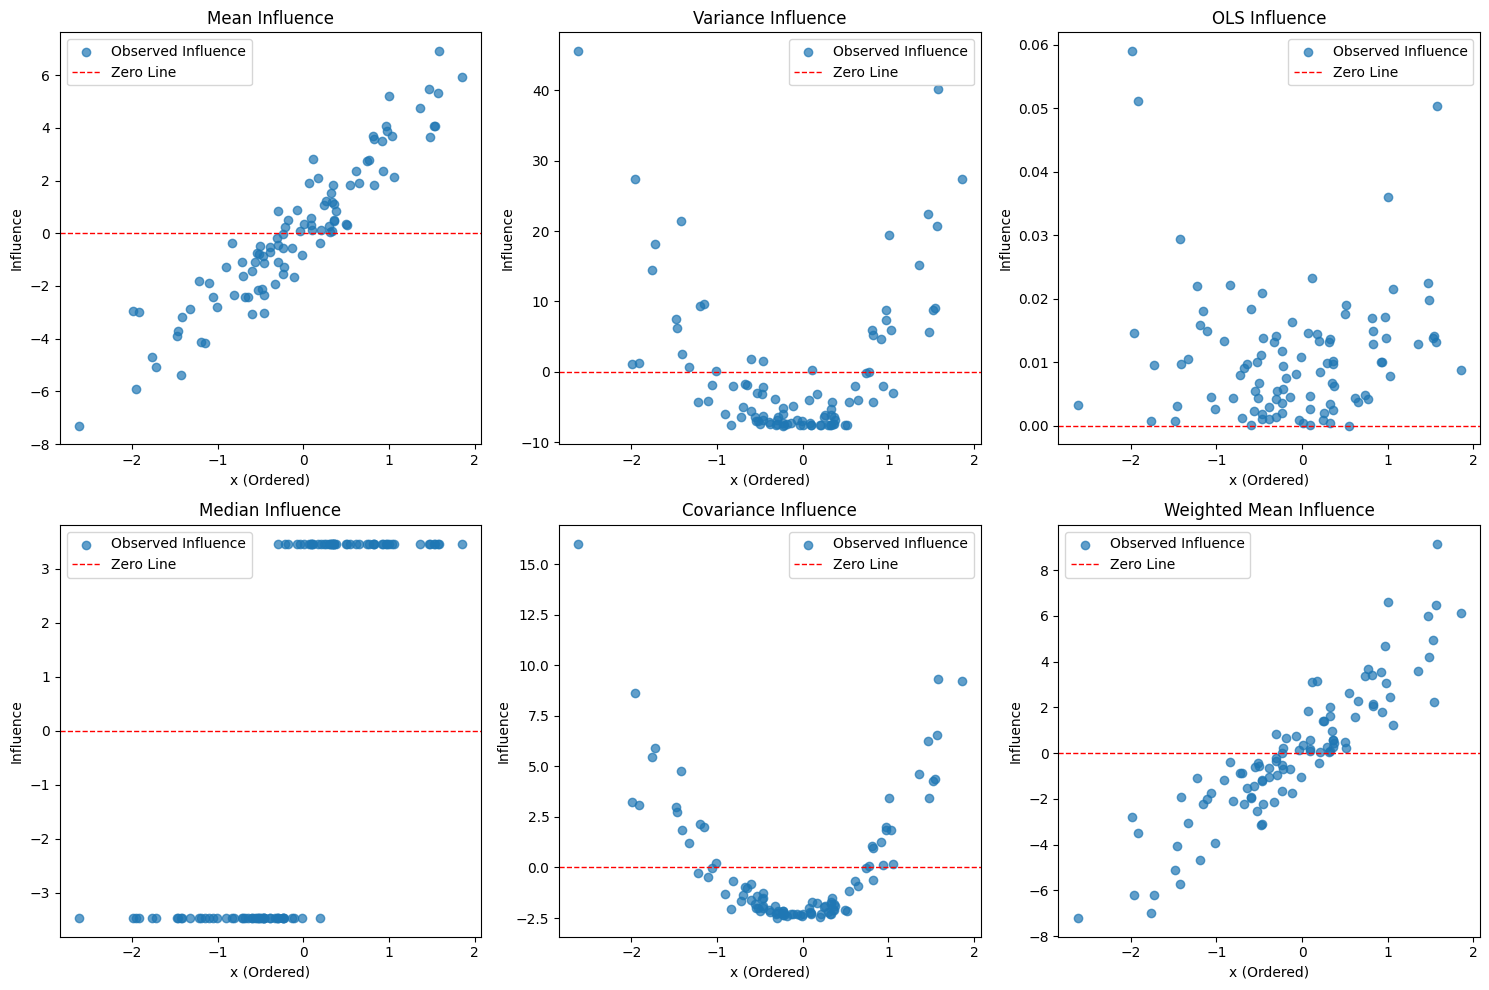

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# Generate data
np.random.seed(42)
n = 100
x = np.random.normal(0, 1, n)  # Predictor variable
y = 3 * x + np.random.normal(0, 1, n)  # Response variable

# Add constant for intercept in OLS
X = np.vstack([np.ones(n), x]).T

# Estimators
# Mean
y_mean = np.mean(y)
# Variance
y_var = np.var(y, ddof=1)
# OLS coefficients
beta = np.linalg.inv(X.T @ X) @ X.T @ y
# Median
y_median = np.median(y)
# Kernel density estimation for median influence
kde = gaussian_kde(y)
density_at_median = kde(y_median)[0]

# Covariance
mean_x = np.mean(x)
mean_y = np.mean(y)
cov_xy = np.mean((x - mean_x) * (y - mean_y))

# Influence functions
# Mean
mean_influence = y - y_mean
# Variance
var_influence = (y - y_mean) ** 2 - y_var
# OLS
ols_influence = []
for i in range(n):
    leverage = X[i, :]
    residual = y[i] - X[i, :] @ beta
    influence_i = np.linalg.inv(X.T @ X) @ leverage * residual
    ols_influence.append(np.linalg.norm(influence_i))
ols_influence = np.array(ols_influence)
# Median
median_influence = np.where(
    y > y_median, 0.5 / density_at_median,
    np.where(y < y_median, -0.5 / density_at_median, 0)
)
# Covariance
cov_influence = (x - mean_x) * (y - mean_y) - cov_xy
# Weighted Mean
weights = np.random.uniform(0.5, 1.5, size=n)
weighted_mean = np.sum(weights * y) / np.sum(weights)
weighted_mean_influence = (weights / np.mean(weights)) * (y - weighted_mean)
# Inverse Weighted Mean
weights_inverse = 1 / (x - x.min() + 1)
weights_inverse = weights_inverse / np.sum(weights_inverse)
weighted_mean_inverse = np.sum(weights_inverse * y)
weighted_mean_influence_inverse = (weights_inverse / np.mean(weights_inverse)) * (y - weighted_mean_inverse)

# Sort data by x for plotting
sorted_indices = np.argsort(x)
x_sorted = x[sorted_indices]
data_sorted = {
    'y': y[sorted_indices],
    'Mean Influence': mean_influence[sorted_indices],
    'Variance Influence': var_influence[sorted_indices],
    'OLS Influence': ols_influence[sorted_indices],
    'Median Influence': median_influence[sorted_indices],
    'Covariance Influence': cov_influence[sorted_indices],
    'Weighted Mean Influence': weighted_mean_influence[sorted_indices],
    'Inverse Weighted Mean Influence': weighted_mean_influence_inverse[sorted_indices]
}

# Unified plotting in a 2x3 grid without Inverse Weighted Mean
plt.figure(figsize=(15, 10))

# Helper function for overlaying true influence
def plot_with_true_influence(ax, x_sorted, influence, title, true_line=None):
    ax.scatter(x_sorted, influence, alpha=0.7, label='Observed Influence')
    ax.axhline(0, color='red', linestyle='--', linewidth=1, label='Zero Line')
    if true_line is not None:
        ax.plot(x_sorted, true_line, color='blue', linestyle='-', linewidth=2, label='True Influence')
    ax.set_title(title)
    ax.set_xlabel('x (Ordered)')
    ax.set_ylabel('Influence')
    ax.legend()

# Mean Influence
ax1 = plt.subplot(2, 3, 1)
plot_with_true_influence(ax1, x_sorted, data_sorted['Mean Influence'], "Mean Influence")

# Variance Influence
ax2 = plt.subplot(2, 3, 2)
plot_with_true_influence(ax2, x_sorted, data_sorted['Variance Influence'], "Variance Influence")

# OLS Influence
ax3 = plt.subplot(2, 3, 3)
plot_with_true_influence(ax3, x_sorted, data_sorted['OLS Influence'], "OLS Influence")

# Median Influence
ax4 = plt.subplot(2, 3, 4)
plot_with_true_influence(ax4, x_sorted, data_sorted['Median Influence'], "Median Influence")

# Covariance Influence
ax5 = plt.subplot(2, 3, 5)
plot_with_true_influence(ax5, x_sorted, data_sorted['Covariance Influence'], "Covariance Influence")

# Weighted Mean Influence
ax6 = plt.subplot(2, 3, 6)
plot_with_true_influence(ax6, x_sorted, data_sorted['Weighted Mean Influence'], "Weighted Mean Influence")

plt.tight_layout()
plt.show()


### Influence Functions for Estimator Variance

- Step 1: Taylor/Expansion  
  From the influence-function representation (assuming i.i.d. $x_i$):  
  $  
    \sqrt{n}(\hat{\theta} - \theta) = \frac{1}{\sqrt{n}} \sum_{i=1}^n \psi_{\theta}(x_i) + o_p(1).  
  $

- Step 2: Asymptotic Variance  
  By the Central Limit Theorem:  
  $  
    \sqrt{n}(\hat{\theta} - \theta) \xrightarrow{d} \mathcal{N}(0, \mathbb{E}[\psi_{\theta}(x)^2]).  
  $  
  Hence:  
  $  
    \mathrm{Var}(\sqrt{n}(\hat{\theta} - \theta)) = \mathbb{E}[\psi_{\theta}(x)^2],  
    \quad  
    \mathrm{Var}(\hat{\theta}) = \frac{1}{n}\mathbb{E}[\psi_{\theta}(x)^2].  
  $

- Step 3: Estimation from Data  
  - Since $\mathbb{E}[\psi_{\theta}(x)] = 0$, we have $\mathbb{E}[\psi_{\theta}(x)^2] = \mathrm{Var}(\psi_{\theta}(x))$.  
  - Approximate this by the sample variance of $\psi_{\theta}(x_i)$. Letting $\psi_i = \psi_{\theta}(x_i)$:  
    $  
      \widehat{\mathbb{E}[\psi_{\theta}(x)^2]} \approx \frac{1}{n-1}\sum_{i=1}^n (\psi_i - \overline{\psi})^2,  
      \quad \text{where } \overline{\psi} \approx 0.  
    $  
  - The asymptotic variance of $\hat{\theta}$ is then estimated as:  
    $  
      \widehat{\mathrm{Var}}(\hat{\theta}) = \frac{1}{n}\widehat{\mathbb{E}[\psi_{\theta}(x)^2]} = \frac{1}{n}\mathrm{Var}(\psi_i) \approx \frac{1}{n(n-1)}\sum_{i=1}^n \psi_i^2.  
    $


In [24]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def get_estimates_and_if_stderr(x, y, weights):
    """
    Returns a dict of:
      {
        'mean': (estimate, IF-std),
        'variance': (estimate, IF-std),
        'median': (estimate, IF-std),
        'cov': (estimate, IF-std),
        'wmean': (estimate, IF-std)
      }
    """
    n = len(y)
    # --- 1) Mean ---
    mu = np.mean(y)
    mean_influence = y - mu
    var_mean_if = np.sum(mean_influence**2) / (n**2)
    mean_if_std = np.sqrt(var_mean_if)

    # --- 2) Variance ---
    var_est = np.var(y, ddof=1)
    var_influence = (y - mu)**2 - var_est
    var_var_if = np.sum(var_influence**2) / (n**2)
    var_if_std = np.sqrt(var_var_if)

    # --- 3) Median ---
    med = np.median(y)
    # Density at median
    kde = gaussian_kde(y)
    f_med = kde(med)[0]
    # IF for median = sign(y_i - med)/(2 * f_med) if y_i != med
    median_influence = 0.5/f_med * np.sign(y - med)
    # Sample-based variance of the sum of influences
    var_median_if = np.sum(median_influence**2) / (n**2)
    median_if_std = np.sqrt(var_median_if)

    # --- 4) Covariance(X, Y) ---
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    cov_xy = np.mean((x - mean_x)*(y - mean_y))
    cov_influence = (x - mean_x)*(y - mean_y) - cov_xy
    var_cov_if = np.sum(cov_influence**2) / (n**2)
    cov_if_std = np.sqrt(var_cov_if)

    # --- 5) Weighted Mean ---
    # Weighted mean = sum(w_i*y_i)/sum(w_i), IF = (w_i/sum(w_i))*(y_i - wmean)
    w_sum = np.sum(weights)
    wmean = np.sum(weights*y)/w_sum
    wmean_influence = (weights / w_sum) * (y - wmean)
    var_wmean_if = np.sum(wmean_influence**2)/(n**2)
    wmean_if_std = np.sqrt(var_wmean_if)

    return {
        "mean": (mu, mean_if_std),
        "variance": (var_est, var_if_std),
        "median": (med, median_if_std),
        "cov": (cov_xy, cov_if_std),
        "wmean": (wmean, wmean_if_std)
    }

# --- Monte Carlo ---
M = 1000
n = 100
true_beta1 = 3.0

all_stats = {
    "mean": [],
    "variance": [],
    "median": [],
    "cov": [],
    "wmean": []
}

all_if_stds = {
    "mean": [],
    "variance": [],
    "median": [],
    "cov": [],
    "wmean": []
}

np.random.seed(42)
for _ in range(M):
    # Generate data
    x = np.random.normal(0, 1, n)
    y = true_beta1*x + np.random.normal(0, 1, n)

    # For weighted mean
    weights = np.random.uniform(0.5, 1.5, size=n)

    # Get estimates + IF-based stderrs
    out = get_estimates_and_if_stderr(x, y, weights)

    # Store
    for k in out.keys():
        all_stats[k].append(out[k][0])     # estimate
        all_if_stds[k].append(out[k][1])   # IF-based std

def summarize(k):
    est_array = np.array(all_stats[k])
    ifstd_array = np.array(all_if_stds[k])
    avg_est = np.mean(est_array)
    avg_ifstd = np.mean(ifstd_array)
    mc_std = np.std(est_array, ddof=1)  # empirical (MC) std dev
    return [k.capitalize(), avg_est, avg_ifstd, mc_std]

table = []
for estimator_name in ["mean", "variance", "median", "cov", "wmean"]:
    table.append(summarize(estimator_name))

df = pd.DataFrame(
    table,
    columns=["Estimator", "Avg Estimate", "Avg IF-StdErr", "MC-StdErr"]
)
print(df)


import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def get_estimates_and_if_stderr(x, y, weights):
    n = len(y)
    # Mean
    mu = np.mean(y)
    mean_influence = y - mu
    mean_if_std = np.sqrt(np.sum(mean_influence**2) / (n**2))

    # Variance
    var_est = np.var(y, ddof=1)
    var_influence = (y - mu)**2 - var_est
    var_if_std = np.sqrt(np.sum(var_influence**2)/(n**2))

    # Median
    med = np.median(y)
    kde = gaussian_kde(y)
    f_med = kde(med)[0]
    median_influence = 0.5/f_med * np.sign(y - med)
    median_if_std = np.sqrt(np.sum(median_influence**2)/(n**2))

    # Covariance
    mean_x = np.mean(x)
    cov_xy = np.mean((x - mean_x)*(y - mu))
    cov_influence = (x - mean_x)*(y - mu) - cov_xy
    cov_if_std = np.sqrt(np.sum(cov_influence**2)/(n**2))

    # Weighted Mean
    w_sum = np.sum(weights)
    wmean = np.sum(weights*y)/w_sum
    wmean_influence = (weights/w_sum)*(y - wmean)
    wmean_if_std = np.sqrt(np.sum(wmean_influence**2)/(n**2))

    return {
        "mean": (mu, mean_if_std),
        "variance": (var_est, var_if_std),
        "median": (med, median_if_std),
        "cov": (cov_xy, cov_if_std),
        "wmean": (wmean, wmean_if_std)
    }

M = 1000
n = 100

# Generate a single set of fixed weights
fixed_weights = np.random.uniform(0.5, 1.5, size=n)

results_dict = {"mean": [], "variance": [], "median": [], "cov": [], "wmean": []}
results_if = {"mean": [], "variance": [], "median": [], "cov": [], "wmean": []}

np.random.seed(42)
for _ in range(M):
    x = np.random.normal(0, 1, n)
    y = 3*x + np.random.normal(0, 1, n)

    out = get_estimates_and_if_stderr(x, y, fixed_weights)
    for k in out.keys():
        results_dict[k].append(out[k][0])
        results_if[k].append(out[k][1])

def summary_stats(name):
    est_arr = np.array(results_dict[name])
    if_arr = np.array(results_if[name])
    return [
        name.capitalize(),
        np.mean(est_arr),
        np.mean(if_arr),
        np.std(est_arr, ddof=1)
    ]

table = []
for est_name in ["mean", "variance", "median", "cov", "wmean"]:
    table.append(summary_stats(est_name))

df = pd.DataFrame(table, columns=["Estimator","Avg Estimate","Avg IF-StdErr","MC-StdErr"])
print(df)


  Estimator  Avg Estimate  Avg IF-StdErr  MC-StdErr
0      Mean      0.007461       0.313794   0.309254
1  Variance      9.998033       1.372169   1.440045
2    Median      0.012924       0.423061   0.378329
3       Cov      2.974772       0.423570   0.436692
4     Wmean      0.011472       0.003252   0.317047


In [25]:
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde

def get_estimates_and_if_stderr(x, y, weights):
    n = len(y)
    # Mean
    mu = np.mean(y)
    mean_influence = y - mu
    mean_if_std = np.sqrt(np.sum(mean_influence**2) / (n**2))

    # Variance
    var_est = np.var(y, ddof=1)
    var_influence = (y - mu)**2 - var_est
    var_if_std = np.sqrt(np.sum(var_influence**2)/(n**2))

    # Median
    med = np.median(y)
    kde = gaussian_kde(y)
    f_med = kde(med)[0]
    median_influence = 0.5/f_med * np.sign(y - med)
    median_if_std = np.sqrt(np.sum(median_influence**2)/(n**2))

    # Covariance
    mean_x = np.mean(x)
    cov_xy = np.mean((x - mean_x)*(y - mu))
    cov_influence = (x - mean_x)*(y - mu) - cov_xy
    cov_if_std = np.sqrt(np.sum(cov_influence**2)/(n**2))

    # Weighted Mean
    w_sum = np.sum(weights)
    wmean = np.sum(weights*y)/w_sum
    wmean_influence = (weights/w_sum)*(y - wmean)
    wmean_if_std = np.sqrt(np.sum(wmean_influence**2)/(n**2))

    return {
        "mean": (mu, mean_if_std),
        "variance": (var_est, var_if_std),
        "median": (med, median_if_std),
        "cov": (cov_xy, cov_if_std),
        "wmean": (wmean, wmean_if_std)
    }

M = 1000
n = 100

# Generate a single set of fixed weights
fixed_weights = np.random.uniform(0.5, 1.5, size=n)

results_dict = {"mean": [], "variance": [], "median": [], "cov": [], "wmean": []}
results_if = {"mean": [], "variance": [], "median": [], "cov": [], "wmean": []}

np.random.seed(42)
for _ in range(M):
    x = np.random.normal(0, 1, n)
    y = 3*x + np.random.normal(0, 1, n)

    out = get_estimates_and_if_stderr(x, y, fixed_weights)
    for k in out.keys():
        results_dict[k].append(out[k][0])
        results_if[k].append(out[k][1])

def summary_stats(name):
    est_arr = np.array(results_dict[name])
    if_arr = np.array(results_if[name])
    return [
        name.capitalize(),
        np.mean(est_arr),
        np.mean(if_arr),
        np.std(est_arr, ddof=1)
    ]

table = []
for est_name in ["mean", "variance", "median", "cov", "wmean"]:
    table.append(summary_stats(est_name))

df = pd.DataFrame(table, columns=["Estimator","Avg Estimate","Avg IF-StdErr","MC-StdErr"])
print(df)


  Estimator  Avg Estimate  Avg IF-StdErr  MC-StdErr
0      Mean      0.008308       0.312977   0.319726
1  Variance      9.944869       1.362551   1.421105
2    Median      0.007967       0.421879   0.390125
3       Cov      2.948505       0.419030   0.433091
4     Wmean      0.011465       0.003249   0.334641


In [26]:
import numpy as np
import pandas as pd

# --------------------------------------------------------------
# 1. Data Generation
# --------------------------------------------------------------
np.random.seed(1235)
N = 100
df = pd.DataFrame({'x': np.random.rand(N)})

# --------------------------------------------------------------
# 2. Sample Mean & Basic Info
# --------------------------------------------------------------
sample_mean = df['x'].mean()
sample_sd = df['x'].std(ddof=1)  # Sample std with unbiased denom
sample_se = sample_sd / np.sqrt(N)

# --------------------------------------------------------------
# 3. Weighted Mean Function
# --------------------------------------------------------------
def wmean(data, w):
    """
    data: pd.DataFrame with column 'x'
    w: np.array of weights
    returns float
    """
    return (data['x'] * w).sum() / w.sum()

# --------------------------------------------------------------
# 4. Jackknife (LOO)
# --------------------------------------------------------------
def jack(data, stat):
    """
    data: pd.DataFrame with column 'x'
    stat: function(data, w) -> float
    returns array L of size n
    """
    n = len(data)
    w_orig = np.ones(n)
    t_obs = stat(data, w_orig)
    L = np.zeros(n)
    for i in range(n):
        w = w_orig.copy()
        w[i] = 0.0  # remove one observation's weight
        L[i] = n * t_obs - (n - 1) * stat(data, w)
    return L - t_obs  # de-mean

Lj = jack(df, wmean)
jack_mean_Lj = Lj.mean()
jack_se_Lj = np.sqrt(Lj.var(ddof=1) / N)  # or /n in the R code

# --------------------------------------------------------------
# 5. Infinitesimal Jackknife
# --------------------------------------------------------------
def ij(data, stat, eps=0.001):
    """
    data: pd.DataFrame with column 'x'
    stat: function(data, w) -> float
    eps: small perturbation
    returns array L of size n
    """
    n = len(data)
    eps_adj = eps / n
    w_orig = np.ones(n)
    t_obs = stat(data, w_orig)
    L = np.zeros(n)
    for i in range(n):
        w = w_orig.copy()
        w[i] += eps_adj
        L[i] = n * (stat(data, w) - t_obs) / eps_adj
    return L

Lij = ij(df, wmean)

# Compare with original x
est_ij = (df['x'] + Lij).mean()
se_ij = np.sqrt(np.var(Lij, ddof=1) / N)
z_crit = 1.96
ci_ij = (est_ij - z_crit * se_ij, est_ij + z_crit * se_ij)

# --------------------------------------------------------------
# 6. Collect Results in a Table
# --------------------------------------------------------------
results = {
    'Description': [
        'Sample Mean',
        'Sample Std Error',
        'Jackknife Mean(Lj)',
        'Jackknife SE(Lj)',
        'IJ-based Estimate',
        'IJ-based Std Error',
        'IJ-based CI Lower',
        'IJ-based CI Upper'
    ],
    'Value': [
        sample_mean,
        sample_se,
        jack_mean_Lj,
        jack_se_Lj,
        est_ij,
        se_ij,
        ci_ij[0],
        ci_ij[1]
    ]
}

summary_table = pd.DataFrame(results)
print(summary_table)


          Description         Value
0         Sample Mean  5.226721e-01
1    Sample Std Error  2.877150e-02
2  Jackknife Mean(Lj)  3.224088e-15
3    Jackknife SE(Lj)  2.877150e-02
4   IJ-based Estimate  5.226721e-01
5  IJ-based Std Error  2.877150e-02
6   IJ-based CI Lower  4.662799e-01
7   IJ-based CI Upper  5.790642e-01
